In [13]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian, plot_decision_boundary
from Neural_Network import NLM,Classifier
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc

In [2]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

In [3]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot

    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.2, color='green', label='class 2')


    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    print(n)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=True)
        xx = polynomial_features.fit_transform(xx)

    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5

    i = 0

    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        i += 1

    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')

    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes, forward, weights):
        self.intercept = intercept
        self.slopes = slopes
        self.forward = forward
        self.weights = weights

    def predict(self, x):
        print(x.shape)
        print(self.slopes.shape)
        #y = sigmoid((x.reshape(-1,20)).dot(self.slopes) + self.intercept)
        #y = sigmoid((x).dot(self.slopes) + self.intercept)
        y=self.forward(self.weights, x.T)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

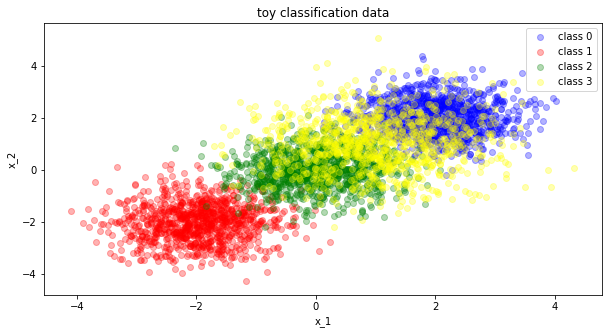

In [16]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params_4 = {'mean': [1, 1], 'covariance_matrix': 1 * np.eye(2)}

params = [params_1, params_2,params_3,params_4]
x, y = two_clusters_gaussian(params, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')
ax.scatter(x[y == 3, 0], x[y == 3, 1], alpha=0.3, color='yellow', label='class 3')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

# test BNN
* 3 classes
* output dim =3
* 2000 samples, step size 1e-2m

In [6]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn2 = Feedforward(architecture, random=random)

In [7]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn2.fit(x.T, y.reshape(3,-1), params)

Iteration 0 lower bound 14152.964889348299; gradient mag: 4786.241727800294
Iteration 100 lower bound 13791.709326705415; gradient mag: 606.3967848062211
Iteration 200 lower bound 13696.79617696197; gradient mag: 527.8704660057027
Iteration 300 lower bound 13620.49705736421; gradient mag: 461.6136430954322
Iteration 400 lower bound 13496.789573433984; gradient mag: 497.2401769650568
Iteration 500 lower bound 13222.857953396326; gradient mag: 539.0298199319332


KeyboardInterrupt: 

In [ ]:
print(nn2.forward(nn2.weights,x.T)[0][0][:100],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0][100:200],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0][200:],'\n')

In [9]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn2.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn2.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    #print(constant)
    exponential = (-0.5 * sigma_y**-2 * np.sum((y.reshape((1, 1, D_bayes)) - (nn2.forward(W, x.T)))**2, axis=2).flatten()).mean()
    #print(exponential)
    return constant + exponential

q=hmc(log_prior, log_likelihood, **params_hmc)


log_likelihood(nn2.weights)

100 : 0.99 False
200 : 0.975 False
300 : 0.9633333333333334 False
400 : 0.93 False
500 : 0.906 False
600 : 0.9 False
700 : 0.8871428571428571 False
800 : 0.86875 False
900 : 0.86 False
1000 : 0.86 False
1100 : 0.8572727272727273 False
1200 : 0.8666666666666667 False
1300 : 0.8523076923076923 False
1400 : 0.8621428571428571 False
1500 : 0.8546666666666667 False
1600 : 0.856875 False
1700 : 0.8647058823529412 False
1800 : 0.8722222222222222 False
1900 : 0.8752631578947369 False


-2133.2993496196264

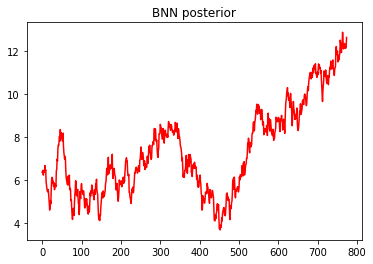

In [10]:
q_=np.asarray(q).T
plt.plot(range(len(q_[0])),q_[0] , color='r')
plt.title('BNN posterior')
plt.show()

120
(14400, 2)
(92,)


ValueError: cannot reshape array of size 43200 into shape (120,120)

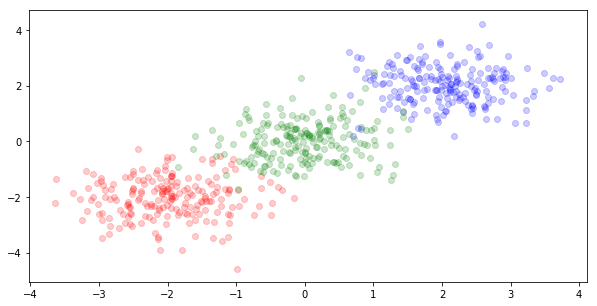

In [27]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
model=Bayesian_logistic_regression(nn2.weights[0][-1],nn2.weights[0][:-1],nn2.forward,nn2.weights)
ax = plot_decision_boundary(x, y, [model], ax, poly_degree=1,  shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

# NLM

In [17]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 2
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)

In [18]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)
from sklearn.model_selection import train_test_split
from pandas import get_dummies

y_ = get_dummies(y).values
print(y_)
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nlm.fit_MLE(X_train.T, y_train.T, params)

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
Iteration 0 lower bound 4.741111137835887; gradient mag: 9.04930047783818
Iteration 100 lower bound 2.0720729911251294; gradient mag: 4.763193404314275
Iteration 200 lower bound 1.386101694855509; gradient mag: 1.5926599304160238
Iteration 300 lower bound 1.1674595674103423; gradient mag: 0.8386946229696762
Iteration 400 lower bound 1.0109747407071068; gradient mag: 0.6437589948452027
Iteration 500 lower bound 0.8830303142937987; gradient mag: 0.5548132264291646
Iteration 600 lower bound 0.7813769105295475; gradient mag: 0.4763077781544821
Iteration 700 lower bound 0.7034707086864503; gradient mag: 0.402272910585694
Iteration 800 lower bound 0.6451426026728734; gradient mag: 0.3283918671169721
Iteration 900 lower bound 0.6022993136585768; gradient mag: 0.26348241658670496
Iteration 1000 lower bound 0.5713489005197945; gradient mag: 0.21085678046697987
Iteration 1100 lower bound 0.5487713538730212; gradient mag: 0.1

Iteration 10000 lower bound 0.4299657565326887; gradient mag: 0.002039072208324257
Iteration 10100 lower bound 0.4299293914413627; gradient mag: 0.0023163824317833136
Iteration 10200 lower bound 0.4298968038316616; gradient mag: 0.002425200187552106
Iteration 10300 lower bound 0.4298610151479831; gradient mag: 0.004167665210701825
Iteration 10400 lower bound 0.4298295849432862; gradient mag: 0.0039504231069365375
Iteration 10500 lower bound 0.42978713107991207; gradient mag: 0.002020372747130462
Iteration 10600 lower bound 0.42975540566688664; gradient mag: 0.004303843019157161
Iteration 10700 lower bound 0.4297309792617168; gradient mag: 0.0037118659399516894
Iteration 10800 lower bound 0.4297098744842339; gradient mag: 0.006640925667078941
Iteration 10900 lower bound 0.42968545188939716; gradient mag: 0.004423065340677075
Iteration 11000 lower bound 0.4296646403935205; gradient mag: 0.002760166815685631
Iteration 11100 lower bound 0.42964600838822903; gradient mag: 0.0043535749720548

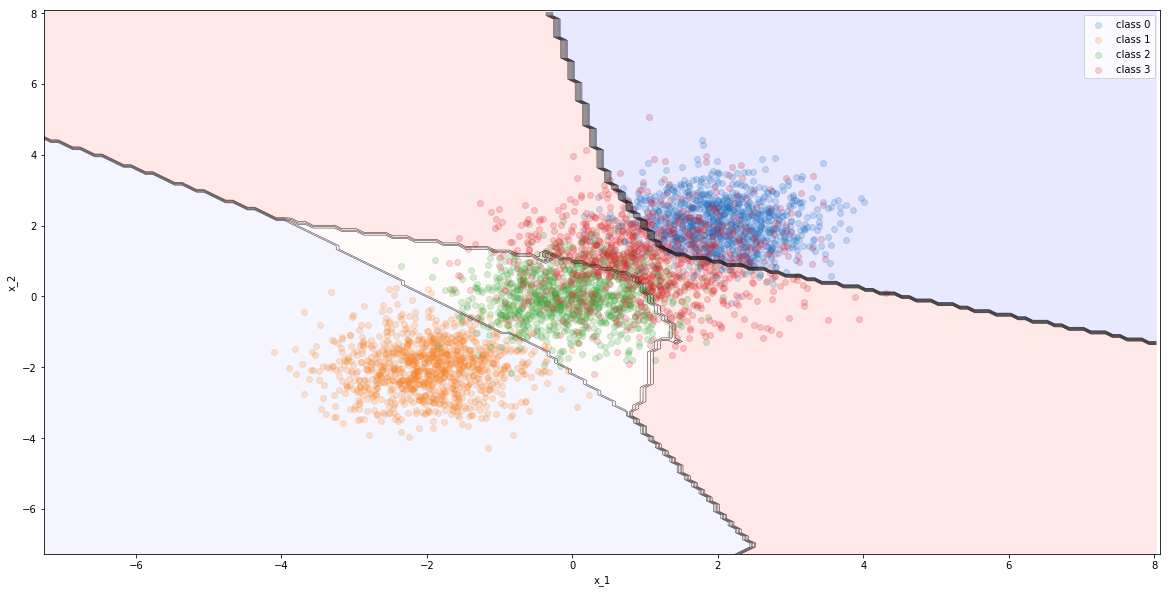

In [19]:
classifier = [Classifier(nlm.weights, nlm.forward)]
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y_, classifier, ax)
plt.show()

In [7]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nlm.weights,
       'burn':.1, 
       'thin':2,}

sigmoid_probability=nlm.forward(nlm.weights, x.T)
sigmoid_probability = np.clip(sigmoid_probability, 1e-15, 1 - 1e-15)
bce = np.dot(np.log(sigmoid_probability),y.flatten())
bce1 = sum([np.dot(np.log(sigmoid_probability)[:,:,i],y.flatten()[i]) for i in range(len(y.flatten()))])
#-sum([p[i]*log2(q[i]) for i in range(len(p))])
#print(bce,'\n',bce1)


nlm.forward(nlm.weights,x.T)[0][0].reshape(3,-1)


array([[1.27780314e-09, 1.38795167e-12, 1.05730483e-12, 2.61426887e-04,
        4.27884057e-09, 1.80084168e-09, 7.63562123e-13, 4.28096138e-11,
        2.13897832e-10, 1.48372934e-07, 7.32999013e-09, 5.93179753e-14,
        5.17740538e-10, 3.97108604e-06, 1.46949712e-12, 5.87089301e-13,
        3.53616637e-18, 6.43176470e-06, 2.98421466e-04, 1.59075421e-07,
        4.55750294e-13, 4.79966123e-09, 4.89295289e-10, 2.44223377e-16,
        1.71479709e-09, 2.01728093e-08, 7.40810938e-09, 1.83164787e-10,
        1.81497907e-12, 3.27719313e-04, 1.34383660e-15, 5.21417021e-12,
        3.86572217e-11, 8.37821185e-13, 3.46454707e-10, 5.59627727e-15,
        1.55858144e-05, 4.02799051e-13, 1.31930335e-12, 3.00849249e-06,
        3.65331692e-07, 3.92492747e-13, 1.58813895e-12, 1.00724517e-06,
        8.26135653e-10, 1.13277230e-12, 1.84500653e-14, 1.55917018e-06,
        8.80623797e-16, 1.42352061e-06, 2.81137919e-09, 3.66429950e-10,
        1.40112342e-06, 1.91923285e-08, 1.28947748e-08, 4.274438

In [8]:
print(nlm.weights)
nlm.fit_NLM(x.T, y.reshape(1,-1),hmc,params_hmc)

[[ 3.1089863   0.6828795   1.2991278   3.27226602  2.83118204 -0.28462259
   0.79910624  0.30650745  0.42001222  0.32318271 -2.20514091  0.72237578
   1.14313416 -0.54228225  1.00686694 -0.04478214  1.88008944 -1.33187258
  -0.17190035 -0.94621332 -4.83087724  0.39198575 -0.70790068 -2.92660417
   1.53929766 -5.32701059  1.47042118 -1.35943203 -0.15299444  0.5227377
   0.04952452 -0.09611067 -0.31169079  0.1161419  -0.81710774 -0.29281062
   0.43258994  1.31649267 -0.28847661  2.99833855 -1.54129374 -1.71564697
  -2.21776306  2.77927303 -1.23637149 -2.30826268 -2.60651649  3.61721129
  -1.98219765 -0.48885579 -2.30736917 -2.60552932  3.61581405 -1.98223342
  -0.48886516 -2.1117279  -2.38701544  3.30872554 -1.98768101 -0.49062791
  -0.65032019 -0.65021156 -0.63563691]]
Autograd ArrayBox with value [[ 3.1089863   0.6828795   1.2991278   3.27226602  2.83118204 -0.28462259
   0.79910624  0.30650745  0.42001222  0.32318271 -2.20514091  0.72237578
   1.14313416 -0.54228225  1.00686694 -0.044

AssertionError: 